<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Functions

In [1]:
# imports and constants
import json
import pickle

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

## Javascript

In [2]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

## Load Data

In [4]:
baseline_df = pd.read_excel("ls_data/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

with open("data_pull/ids/wave1_ids.txt", "r") as internal_f:
    wave1_ids = [line.strip() for  line in internal_f.readlines()]

## Functions

In [5]:
def filter_sig_corrs(r_corrs, r_p_vals, cols, target_col, filter_prefix="", alpha=0.05):
    """Builds a df with correlations for the target_col, optionally providing a prefix filter for columns
    
    """
    target_idx = np.where(cols==target_col)
    target_corrs = r_corrs[target_idx]
    target_p_vals = r_p_vals[target_idx]

    target_stats = np.transpose(np.vstack((target_corrs, target_p_vals)))
    target_df = pd.DataFrame(target_stats, index=cols, columns=['corr', 'p'])
    sig_features = target_df.loc[target_df['p'] < alpha]
    sig_features = sig_features.loc[sig_features.index.str.startswith(filter_prefix)]
    pd.options.display.float_format = '{:,.3f}'.format

    return sig_features.sort_values(by='p')


def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

# Baseline State

## PHQ 8

- [PHQ-9 Self-report](http://med.stanford.edu/fastlab/research/imapp/msrs/_jcr_content/main/accordion/accordion_content3/download_256324296/file.res/PHQ9%20id%20date%2008.03.pdf)
- note that question 9 was omitted
- $\ge$ 10 is a positive screen for depression symptoms

**Scoring (PHQ 9 scale)**
- 1-4 Minimal depression
- 5-9 Mild depression
- 10-14 Moderate depression
- 15-19 Moderately severe depression
- 20-27 Severe depression 

In [6]:
init_df = pd.DataFrame()
init_df['study_id'] = baseline_df['study_id']
init_df['pid'] = init_df['study_id'].map(redcap_dict)
init_df['pid'] = init_df['pid'].astype(str)
init_df['pid'] = init_df['pid'].str.pad(width=8, side='left', fillchar='0')

In [7]:
init_df['phq8'] = baseline_df['phq_total_sc']
init_df['phq_q10'] = baseline_df['phq10_sc']

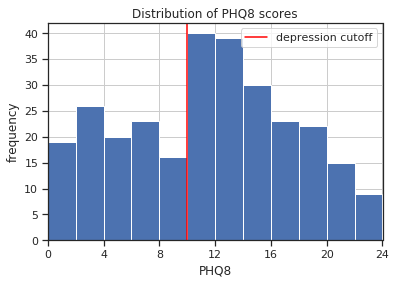

In [8]:
init_df['phq8'].hist(bins=12)
plt.xlim((0,24))
plt.xticks(np.arange(0,25,4))
plt.axvline(x=10, color='red', label="depression cutoff")
plt.xlabel("PHQ8")
plt.ylabel("frequency")
plt.title("Distribution of PHQ8 scores")
plt.legend()
plt.show()

In [9]:
init_df['is_depressed'] = init_df['phq8'] >= 10
init_df['is_depressed'].value_counts()

True     178
False    104
Name: is_depressed, dtype: int64

## Medical Diagnoses

- Has a mental health provider or physician ever diagnosed you with...
    - Major Depressive Disorder/Depression
    - Bipolar Disorder/Manic Depression/Mania
    - Obsessive-compulsive disorder
    - Post Traumatic Stress Disorder
    - Schizophrenia
    - Eating Disorders: anorexia or bulimia nervosa
    - Substance use disorder: alcohol or drugs
    
### Responses

- 77: I don't know
- 99: Prefer not to answer

In [10]:
dx_cols = baseline_df.columns[baseline_df.columns.str.startswith('dx')]
init_df[dx_cols] = baseline_df[dx_cols]

In [11]:
init_df['dx_depression'].value_counts()

1     199
0      81
77      2
Name: dx_depression, dtype: int64

In [12]:
init_df['dx_ptsd'].value_counts()

0     209
1      66
77      7
Name: dx_ptsd, dtype: int64

## GAD

- [GAD7 self-report](mdcalc.com/gad-7-general-anxiety-disorder-7)

### Scoring

- 5-9, Mild, Monitor
- 10-14, Moderate, Possible clinically significant condition
- \>15, Severe, Active treatment probably warranted
- $\ge$ 10 results in a positive screen for generalized anxiety disorder


In [13]:
init_df['gad7'] = baseline_df['gad_total']
init_df['gad_q8'] = baseline_df['gad08']

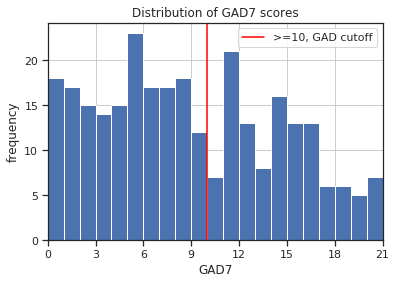

In [14]:
gad_df = init_df.loc[init_df['gad7'] <= 21]
gad_df['gad7'].hist(bins=21)
plt.xlim((0,21))
plt.xticks(np.arange(0,22,3))
plt.axvline(x=10, color='red', label=">=10, GAD cutoff")
plt.xlabel("GAD7")
plt.ylabel("frequency")
plt.title("Distribution of GAD7 scores")
plt.legend()
plt.show()

In [15]:
init_df['is_anxious'] = init_df['gad7'] >= 10
init_df['is_anxious'].value_counts()

False    166
True     116
Name: is_anxious, dtype: int64

## SHAPS

- [SHAPS self-report](https://www.phenxtoolkit.org/toolkit_content/PDF/PX710601.pdf)
- Snaith-Hamilton pleasure scale
    - can be used to measure anhedonia: a diminished or lack of ability to experience and anticipate pleasure
- $\ge$ 2 as anhedonia cutoff

In [16]:
init_df['shaps'] = baseline_df['shaps_score']

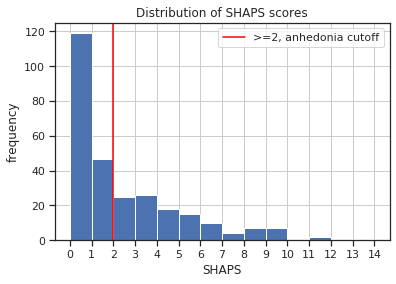

In [17]:
init_df['shaps'].hist(bins=14)
#plt.xlim((0,21))
plt.xticks(np.arange(0,15))
plt.axvline(x=2, color='red', label=">=2, anhedonia cutoff")
plt.xlabel("SHAPS")
plt.ylabel("frequency")
plt.title("Distribution of SHAPS scores")
plt.legend()
plt.show()

In [18]:
init_df['is_anhedonic'] = init_df['shaps'] >= 2

In [19]:
init_df['is_anhedonic'].value_counts()

False    166
True     116
Name: is_anhedonic, dtype: int64

## SPIN

- [SPIN self-report]
- social phobia inventory
- $\ge$ 20 indicator for social phobia

### Scoring

- Less than 20 = None; 
- 21-30 = Mild; 
- 31-40 = Moderate; 
- 41-50 = Severe; 
- 51+ = Very Severe

### SPIN subscales

- fear:
    - 1,3,5,10,14,15
- avoidance:
    - 4,6,8,9,10,11,16
- physiological:
    - 2,7,13,17
    
- mini-SPIN:
    - 6,9,15

In [20]:
init_df['spin'] = baseline_df['spin_totalscore']

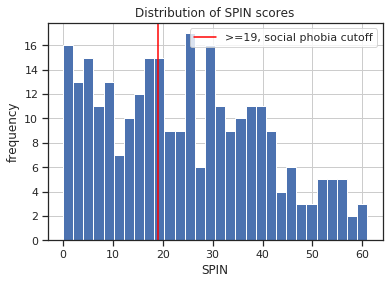

In [21]:
spin_df = init_df.loc[init_df['spin'] <= 100]
spin_df['spin'].hist(bins=30)
#plt.xlim((0,21))
#plt.xticks(np.arange(0,15))
plt.axvline(x=19, color='red', label=">=19, social phobia cutoff")
plt.xlabel("SPIN")
plt.ylabel("frequency")
plt.title("Distribution of SPIN scores")
plt.legend()
plt.show()

# SPIN Response Analysis

- only one PNA response on spin_01
- concerns about censorship/MNAR, [Gelman link](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)

### Data Cleaning

In [22]:
spin_cols = baseline_df.columns[baseline_df.columns.str.contains('spin')][:-1]
#spin_df = init_df.copy()
#spin_df[spin_cols] = baseline_df[spin_cols]
spin_df = baseline_df[spin_cols]

In [23]:
spin_df[spin_df > 4].count(axis=0).sort_values(ascending=False)

spin_01    1
spin_08    0
spin_02    0
spin_03    0
spin_04    0
spin_05    0
spin_06    0
spin_07    0
spin_17    0
spin_16    0
spin_10    0
spin_11    0
spin_12    0
spin_13    0
spin_14    0
spin_15    0
spin_09    0
dtype: int64

In [24]:
spin_01_mean = spin_df.loc[spin_df['spin_01'] <= 4]['spin_01'].mean()

In [181]:
spin_df = spin_df.replace(to_replace=999, value=1)

### Subscale analysis

In [182]:
fear = [1,3,5,10,14,15]
avoid = [4,6,8,9,10,11,16]
physio = [2,7,13,17]
mini = [6,9,15]

def proc_spin_cols(qs):
    col_names = []
    for q in qs:
        name = "spin_0{}" if q < 10 else "spin_{}"
        col_names.append(name.format(q))
    return col_names

fear_cols = proc_spin_cols(fear)
avoid_cols = proc_spin_cols(avoid)
phys_cols = proc_spin_cols(avoid)
mini_cols = proc_spin_cols(mini)

In [183]:
spin_df['spin_fear'] = spin_df[fear_cols].sum(axis=1)
spin_df['spin_avoid'] = spin_df[avoid_cols].sum(axis=1)
spin_df['spin_phys'] = spin_df[phys_cols].sum(axis=1)
spin_df['spin_mini'] = spin_df[mini_cols].sum(axis=1)

In [184]:
init_df['spin_fear'] = spin_df['spin_fear']
init_df['spin_avoid'] = spin_df['spin_avoid']
init_df['spin_phys'] = spin_df['spin_phys']
init_df['spin_mini'] = spin_df['spin_mini']

In [186]:
corr_df = spin_df.copy()
corr_df['spin_total'] = spin_df[spin_cols].sum(axis=1)
cols = ['spin_total', 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']
corr_df = corr_df[cols]

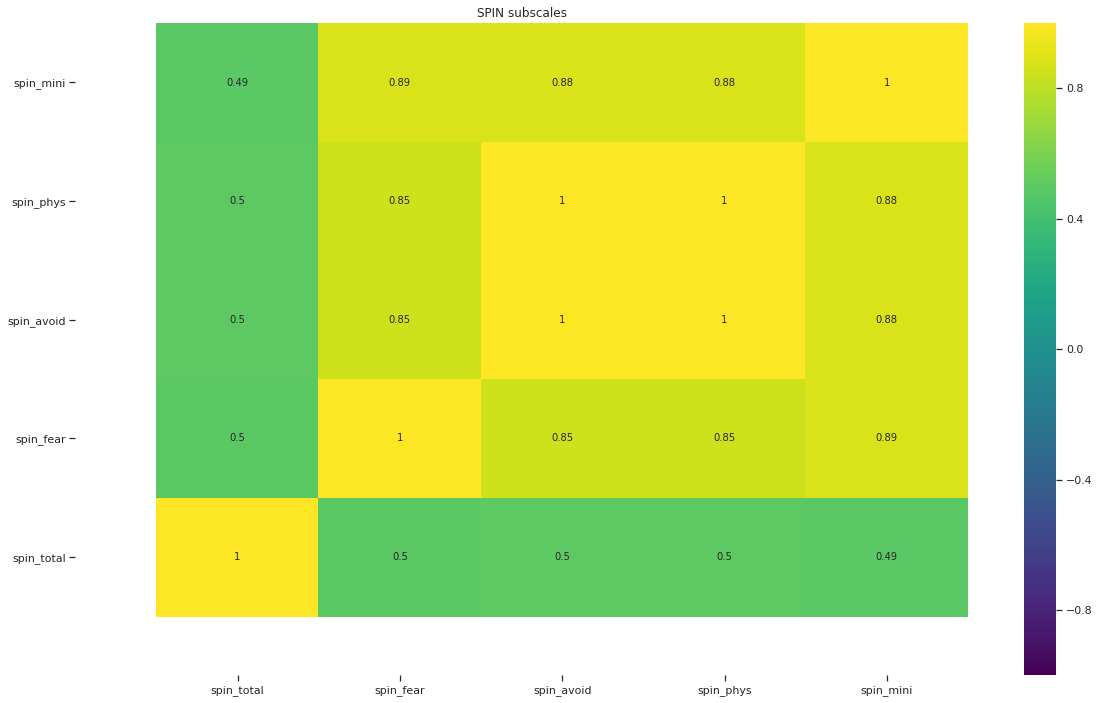

In [189]:
corr_df = corr_df.dropna()
#corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df, corr_type='pearson')
sns.heatmap(corrs, annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.yticks(np.arange(0.5,len(cols)), cols, rotation='horizontal')
plt.xticks(np.arange(0.5,len(cols)), cols, rotation='horizontal')
plt.xlim(-0.5, 5)
plt.ylim(-0.5, 5)

#plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.title("SPIN subscales")
plt.show()


- [original SPIN paper factor analysis](https://www.cambridge.org/core/journals/the-british-journal-of-psychiatry/article/psychometric-properties-of-the-social-phobia-inventory-spin/9E4A3EE20D2B1A6C222CDB5807AC086A/core-reader): 5 factors

#### Questions

1. I am afraid of people in authority.
2. I am bothered by blushing in front of people.
3. Parties and social events scare me.
4. I avoid talking to people I don't know.
5. Being criticized scares me a lot.
6. Fear of embarrassment causes me to avoid doing things or speaking to people.
7. Sweating in front of people causes me distress.
8. I avoid going to parties.
9. I avoid activities in which I am the center of attention.
10. Talking to strangers scares me.
11. I avoid having to give speeches.
12. I would do anything to avoid being criticized.
13. Heart palpitations bother me when I am around people.
14. I am afraid of doing things when people might be watching.
15. Being embarrassed or looking stupid are my worst fears.
16. I avoid speaking to anyone in authority.
17. Trembling or shaking in front of others is distressing to me.

#### Comments

- Q1 and Q16 involve authority
- Q2, 7, 13, 17 involve physiological responses
- Q4, 10 involve strangers
- Q5, 12 involve criticism

# SPIN, GAD, PHQ Combined loadings

## Imports and Functions

In [32]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

def _ortho_rotation(components, method='varimax', tol=1e-6, max_iter=100):
    """Return rotated components.
    
    https://github.com/scikit-learn/scikit-learn/pull/11064/files
    """
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = np.diag((comp_rot ** 2).sum(axis=0)) / nrow
            tmp = np.dot(comp_rot, tmp)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(
            np.dot(components.T, comp_rot ** 3 - tmp))
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return np.dot(components, rotation_matrix).T

In [33]:
spin_cols = baseline_df.columns[baseline_df.columns.str.contains('spin')]
spin_df = baseline_df[spin_cols]
# One PNA in spin01
spin_df = spin_df.replace(to_replace=999, value=1)

In [34]:
gad_cols = baseline_df.columns[baseline_df.columns.str.contains('gad')]
gad_df = baseline_df[gad_cols]
# One PNA in gad06
gad_df = gad_df.replace(to_replace=99, value=1)

In [35]:
phq_cols = baseline_df.columns[baseline_df.columns.str.contains('phq')]
phq_df = baseline_df[phq_cols]

## GAD and PHQ

In [36]:
gad_phq = pd.concat([phq_df, gad_df], axis=1)

In [37]:
drop_cols = ['phq_total_sc', 'phq10_sc', 'gad_total', 'gad08']
gad_phq = gad_phq.drop(drop_cols, axis='columns')

In [38]:
gad_phq_scaled = preprocessing.scale(gad_phq)
pca_transformer = PCA(n_components=5, random_state=0)
pca_transformed = pca_transformer.fit_transform(gad_phq_scaled)

In [39]:
var_df = pd.Series(pca_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df.head()

,var_explained
0,0.503898
1,0.097356
2,0.063911
3,0.049810
4,0.044431


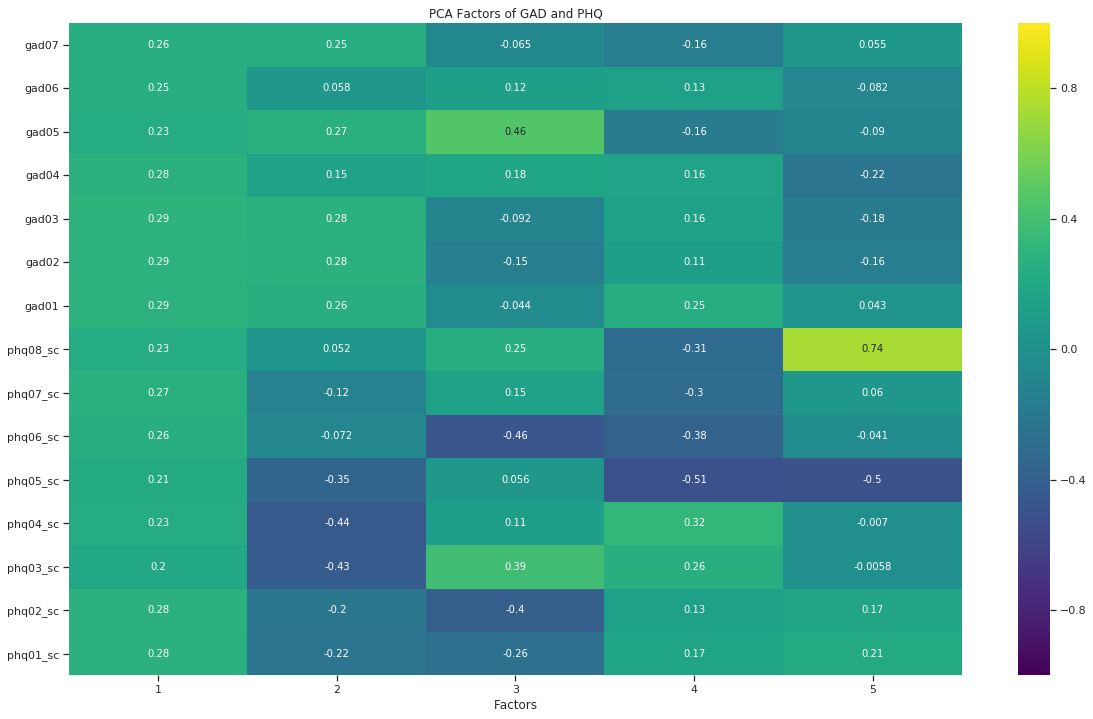

In [40]:
plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(pca_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,15)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,15), gad_phq.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Factors")
plt.title("PCA Factors of GAD and PHQ")
plt.show()

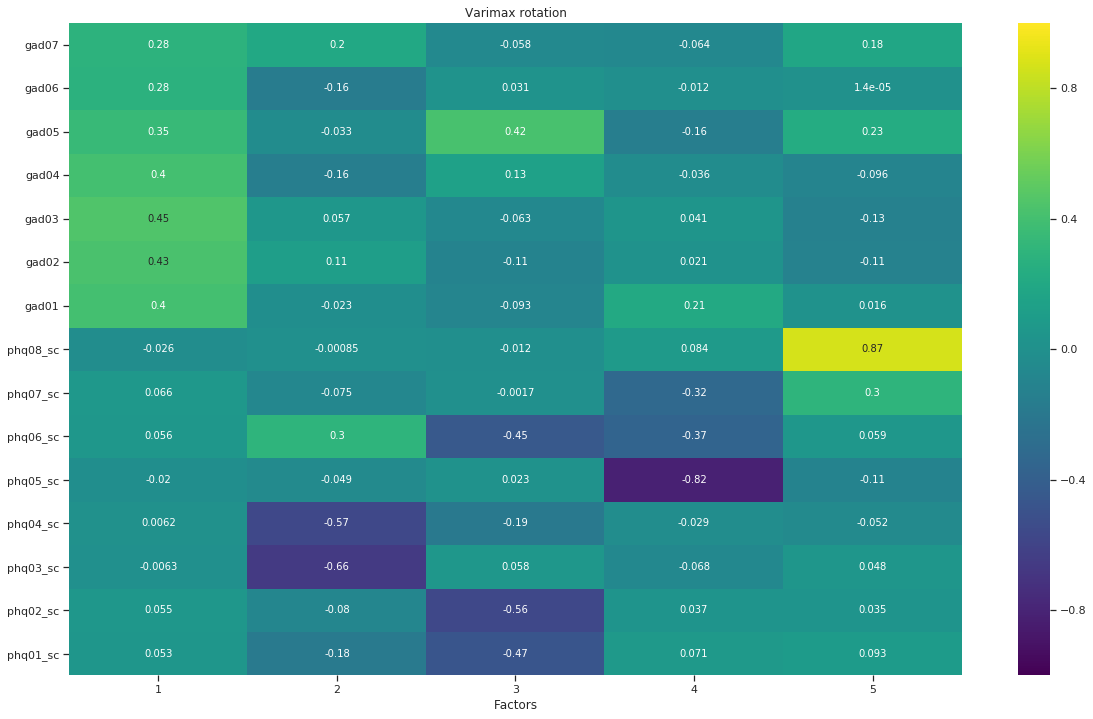

In [41]:
varimax = _ortho_rotation(pca_transformer.components_.T)

plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(varimax), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,15)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,15), gad_phq.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Factors")
plt.title("Varimax rotation")
plt.show()

## GAD, PHQ, SPIN

In [42]:
gad_phq_spin = pd.concat([phq_df, gad_df, spin_df], axis=1)

In [43]:
drop_cols = ['phq_total_sc', 'phq10_sc', 'gad_total', 'gad08', 'spin_totalscore',]# 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']
gad_phq_spin = gad_phq_spin.drop(drop_cols, axis='columns')

In [44]:
gad_phq_spin_scaled = preprocessing.scale(gad_phq_spin)
pca_transformer = PCA(n_components=5, random_state=0)
pca_transformed = pca_transformer.fit_transform(gad_phq_spin_scaled)

In [45]:
pca_transformer.explained_variance_ratio_

array([0.40816429, 0.10028344, 0.05328429, 0.04233262, 0.03910104])

In [46]:
var_df = pd.Series(pca_transformer.explained_variance_ratio_).to_frame()
var_df.columns = ['var_explained']
var_df.head()

,var_explained
0,0.408164
1,0.100283
2,0.053284
3,0.042333
4,0.039101


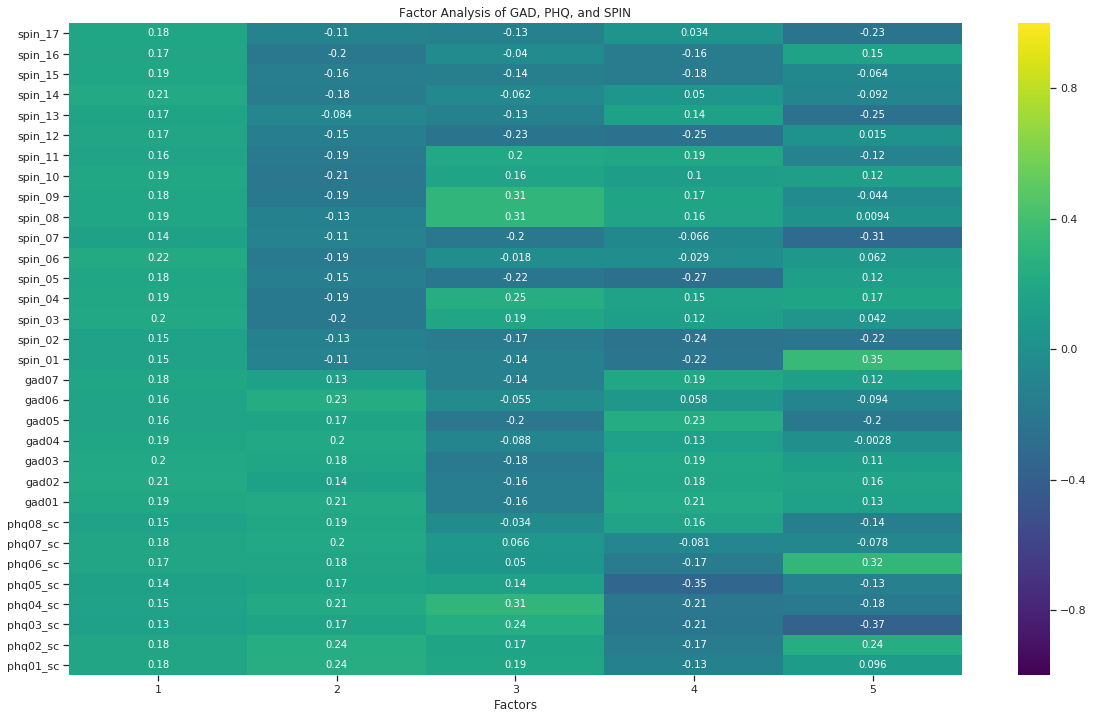

In [47]:
plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(pca_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,32)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,32), gad_phq_spin.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Factors")
plt.title("Factor Analysis of GAD, PHQ, and SPIN")
plt.show()

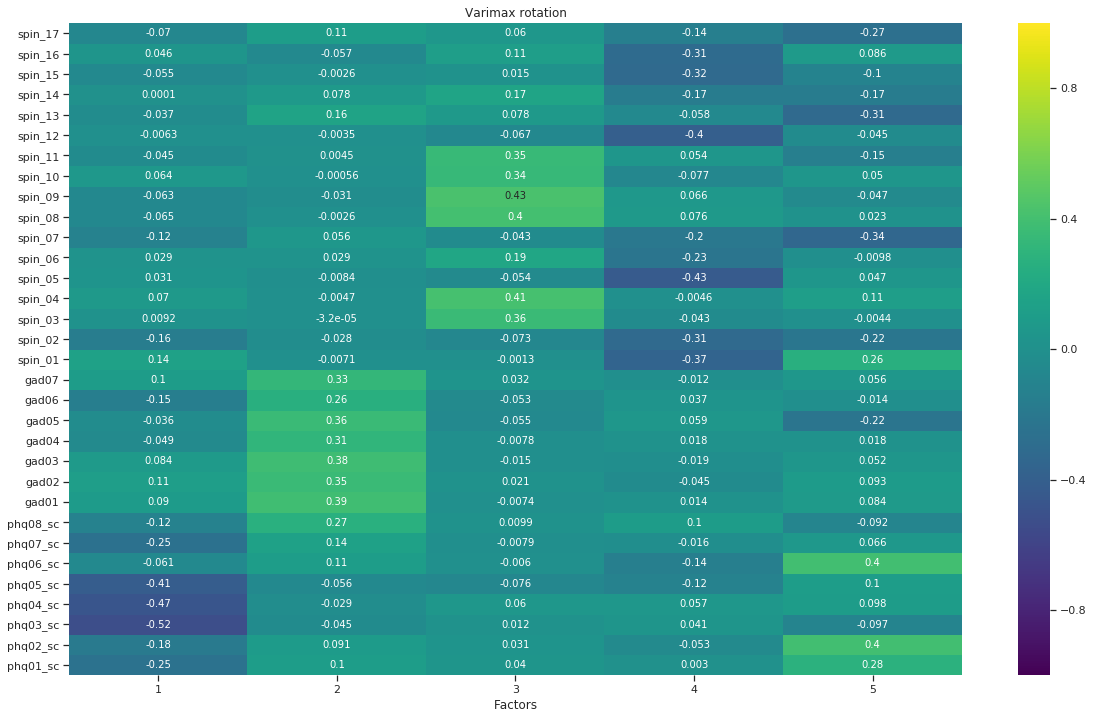

In [48]:
varimax = _ortho_rotation(pca_transformer.components_.T)

plt.rcParams["figure.figsize"] = [20,12]
sns.heatmap(np.transpose(varimax), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.ylim(0,32)
plt.xlim(0,5)
plt.yticks(np.arange(0.5,32), gad_phq_spin.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Factors")
plt.title("Varimax rotation")
plt.show()

## Location Durations

In [49]:
all_sloc_df = pd.read_pickle("ls_data/all_sloc.df")
sloc_hr_all = pd.read_pickle("ls_data/all_sloc_hr.df")
sloc_hr_all.head()

,hr,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur,food_home,...,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions,pid
0,2019-07-27 12:00:00,2700.0,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
1,2019-07-27 13:00:00,1469.0,2120.0,0.0,0.0,0.0,0,0,0.0,1,...,0,0,0,0,0,0,0,0,1,08343773
2,2019-07-27 14:00:00,0.0,3500.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
3,2019-07-27 15:00:00,0.0,3320.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
4,2019-07-27 16:00:00,0.0,3205.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773


In [50]:
dur_cols = list(sloc_hr_all.columns[sloc_hr_all.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = sloc_hr_all[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [51]:
sloc_dur_df = sloc_dur_df.loc[(sloc_dur_df['date'] >= '2019-07-31') & (sloc_dur_df['date'] <= '2019-08-02')]
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [52]:
mean_dur_df.head()

,pid,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur
0,00746649,0.0,26460.666667,10396.000000,0.0,4815.666667,0,0,25612.666667
1,01225297,0.0,52473.333333,8108.666667,0.0,0.000000,0,0,4541.666667
2,01254121,3879.0,35947.333333,4332.000000,0.0,0.000000,0,0,16779.666667
3,01495950,0.0,25604.333333,12278.333333,0.0,0.000000,0,0,530.666667
4,01766910,0.0,20196.333333,0.000000,0.0,11666.666667,0,0,272.000000


In [53]:
mean_dur_df.describe()

,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.0,273.0,273.000000
mean,1031.606838,33048.822955,10370.339438,208.354090,1801.443223,0.0,0.0,13545.194750
std,2476.758598,21243.820546,11491.784460,732.268832,5103.108268,0.0,0.0,17961.741070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,18827.666667,0.000000,0.000000,0.000000,0.0,0.0,3755.666667
50%,0.000000,35029.666667,5568.666667,0.000000,0.000000,0.0,0.0,7642.333333
75%,1277.000000,46475.666667,19701.666667,0.000000,0.000000,0.0,0.0,13710.333333
max,23627.000000,81930.666667,58888.000000,5321.000000,34816.333333,0.0,0.0,80738.333333


In [54]:
spin_dur = init_df[['pid', 'spin', 'gad7', 'phq8']]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

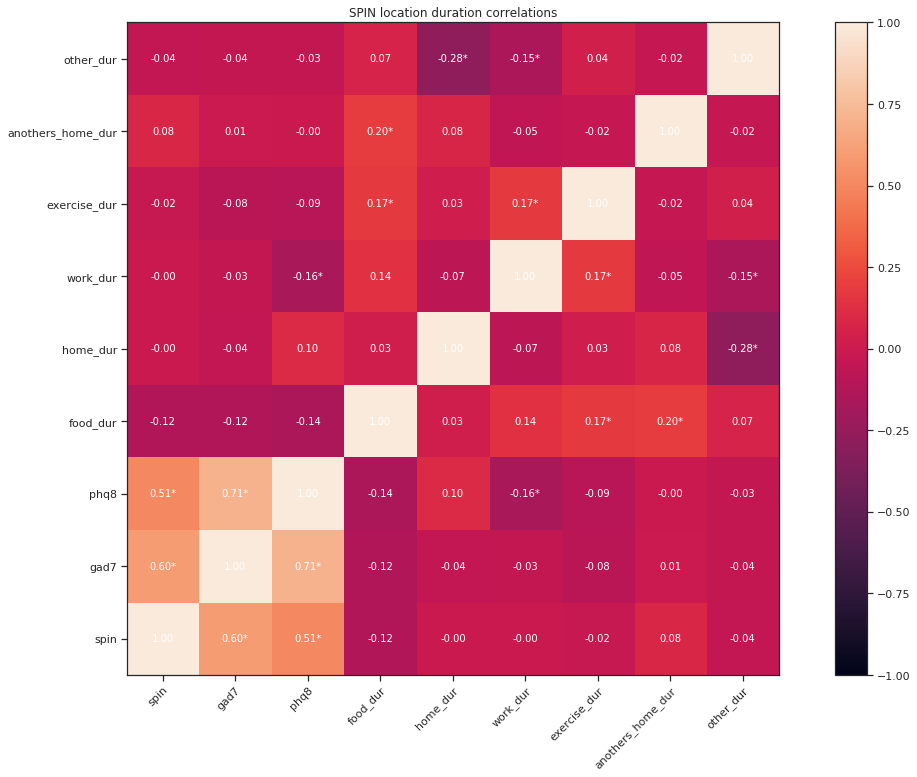

In [55]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'SPIN location duration correlations', 0.05, figsize=[20,12])
plt.show()

### Correlations


In [56]:
spin_dur = init_df[['pid', 'spin', 'gad7', 'phq8']]
spin_dur[spin_cols] = spin_df[spin_cols]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [57]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)
corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_02', alpha=1).iloc[19:]

,corr,p
spin_08,0.251,0.000
anothers_home_dur,0.144,0.028
other_dur,-0.059,0.441
exercise_dur,0.052,0.503
food_dur,-0.026,0.762
work_dur,-0.010,0.917
home_dur,-0.009,0.927


In [58]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_08', alpha=1).iloc[19:]

,corr,p
spin_02,0.251,0.000
work_dur,-0.141,0.032
other_dur,0.086,0.230
exercise_dur,-0.074,0.311
food_dur,-0.055,0.481
home_dur,-0.042,0.608
anothers_home_dur,0.033,0.702


In [59]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_15', alpha=1).iloc[19:]

,corr,p
spin_07,0.364,0.000
food_dur,-0.171,0.007
other_dur,-0.083,0.250
work_dur,0.082,0.255
anothers_home_dur,0.022,0.800
home_dur,-0.011,0.907
exercise_dur,0.002,0.977


## Location Transitions

In [60]:
trans_cols = list(sloc_hr_all.columns[~sloc_hr_all.columns.str.contains("dur")].values)
sloc_trans_df = sloc_hr_all[trans_cols]
sloc_trans_df['date'] = sloc_trans_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
sloc_trans_df = sloc_trans_df.loc[(sloc_trans_df['date'] >= '2019-07-31') & (sloc_trans_df['date'] <= '2019-08-02')]
mean_trans_df = sloc_trans_df.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

In [62]:
mean_trans_df.head()

,pid,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,...,travel_religion,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions
0,00746649,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,2.000,0.000,0.333,0.000,0.000,6.000
1,01225297,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.333,0.000,0.000,0.000,0.000,1.667
2,01254121,0.000,0.000,0.000,0.000,0.000,0.000,1.333,0.000,0.000,...,0.000,0.000,1.000,4.333,0.000,0.000,0.000,0.000,0.000,11.000
3,01495950,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.667,...,0.000,0.000,0.000,0.000,1.333,0.000,0.000,0.000,0.000,3.000
4,01766910,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,1.000


In [63]:
mean_trans_df.describe()

,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,home_exercise,...,travel_religion,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions
count,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,...,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000
mean,0.055,0.026,0.004,0.010,0.000,0.000,0.220,0.051,0.049,0.013,...,0.000,0.000,0.208,1.139,0.556,0.065,0.153,0.000,0.000,4.668
std,0.187,0.113,0.035,0.090,0.000,0.000,0.453,0.183,0.210,0.087,...,0.000,0.000,0.409,1.387,0.909,0.235,0.551,0.000,0.000,4.329
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,1.667
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.333,0.000,0.000,0.000,0.000,4.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000,...,0.000,0.000,0.333,1.333,0.667,0.000,0.000,0.000,0.000,6.333
max,1.333,1.000,0.333,1.333,0.000,0.000,3.667,1.333,2.333,1.000,...,0.000,0.000,3.000,13.667,6.333,1.667,7.333,0.000,0.000,36.333


In [64]:
spin_trans = init_df[['pid', 'spin']]
spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Correlations

In [65]:
corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_12', alpha=1).iloc[17:25]


,corr,p
spin_04,0.331,0.000
other_work,0.167,0.022
other_food,-0.156,0.038
food_other,-0.142,0.070
work_other,0.134,0.089
food_exercise,-0.105,0.241
home_work,0.101,0.275
work_food,-0.100,0.277


In [66]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_07', alpha=1).iloc[17:25]

,corr,p
spin_01,0.258,0.000
anothers_home_other,0.166,0.023
other_anothers_home,0.138,0.078
food_anothers_home,0.138,0.079
anothers_home_work,0.096,0.309
food_work,0.079,0.470
other_work,0.076,0.498
work_food,0.072,0.537


# EMAs

## Morning

In [67]:
morn_ema_df = pd.DataFrame()
all_ids = wave1_ids

for pid in all_ids:
    morn_df = pd.read_pickle("data_pull/morning_ema/{}.df".format(pid))
    morn_ema_df = morn_ema_df.append(morn_df, sort=True)

In [68]:
morn_ema_df['timestamp'] = morn_ema_df['timestamp'].astype(int)
morn_ema_df['timezone-offset'] = morn_ema_df['timezone-offset'].astype(int)
morn_ema_df['sleep-quality'] = morn_ema_df['sleep-quality'].astype(int)
morn_ema_df['mood'] = morn_ema_df['mood'].astype(int)

morn_ema_df['adj_ts'] = morn_ema_df['timestamp'] + morn_ema_df['timezone-offset']
morn_ema_df['date'] = pd.to_datetime(morn_ema_df['adj_ts'], unit='s').dt.floor('d')
morn_ema_df['pid'] = morn_ema_df['source']

In [69]:
morn_ema_cols = ['mood', 'sleep-quality', 'pid', 'date']
morn_emas = morn_ema_df[morn_ema_cols]

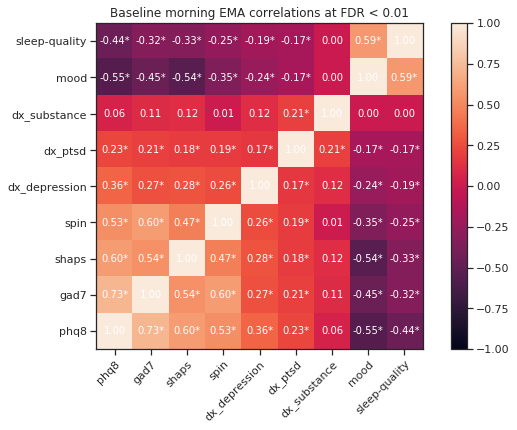

In [70]:
init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(morn_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

## Evening 

In [71]:
even_ema_df = pd.DataFrame()

for pid in wave1_ids:
    even_df = pd.read_pickle("data_pull/evening_ema/{}.df".format(pid))
    even_ema_df = even_ema_df.append(even_df, sort=True)

In [72]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']

In [73]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']
# adjust for yesterday surveys
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].fillna(0)
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].astype(int)
even_ema_df['adj_date'] = even_ema_df['date'] - pd.to_timedelta(even_ema_df['for_yesterday'], unit='D')

even_ema_df['mood'] = even_ema_df['mood'].astype(int)

In [74]:
even_ema_cols = ['mood', 'pid', 'date']
even_emas = even_ema_df[even_ema_cols]

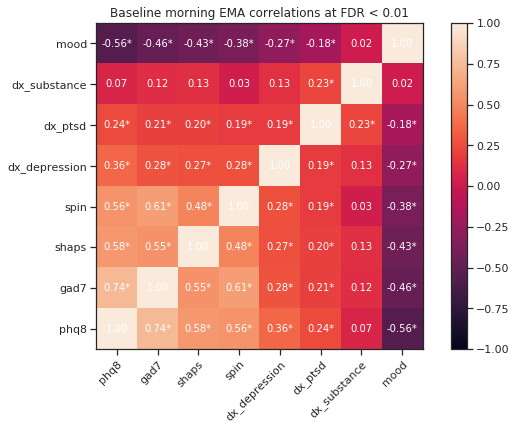

In [75]:
init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(even_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

In [76]:
ema_df = morn_emas.copy()
ema_df = ema_df.rename({'mood': 'morn_mood'}, axis='columns')
ema_df = ema_df.merge(even_emas, on=['pid', 'date'], how='left')
ema_df = ema_df.rename({'mood': 'even_mood'}, axis='columns')

## Evening PHQ8

In [77]:
even_phq8_df = pd.DataFrame()

for pid in all_ids:
    even_df = pd.read_pickle("data_pull/evening_phq8/{}.df".format(pid))
    even_phq8_df = even_phq8_df.append(even_df, sort=True)

In [78]:
even_phq8_df['timestamp'] = even_phq8_df['timestamp'].astype(int)
even_phq8_df['timezone-offset'] = even_phq8_df['timezone-offset'].astype(int)

even_phq8_df['adj_ts'] = even_phq8_df['timestamp'] + even_phq8_df['timezone-offset']
even_phq8_df['date'] = pd.to_datetime(even_phq8_df['adj_ts'], unit='s').dt.floor('d')
even_phq8_df['pid'] = even_phq8_df['source']
# adjust for yesterday surveys
even_phq8_df['for_yesterday'] = even_phq8_df['for_yesterday'].fillna(0)
even_phq8_df['for_yesterday'] = even_phq8_df['for_yesterday'].astype(int)
even_phq8_df['adj_date'] = even_phq8_df['date'] - pd.to_timedelta(even_phq8_df['for_yesterday'], unit='D')

In [79]:
# TODO process health status
#print(even_phq8_df.columns.values)
even_phq8_ema_cols = ['appetite', 'concentration', 'depression', 'difficulty', 'energy', 'feeling-bad', 
                      'mood', 'movement', 'pleasure', 'sleep', 'physical-health']
#even_phq8_ema_cols = ['mood', 'sleep']
even_phq8_df[even_phq8_ema_cols].head()
even_phq8_emas = even_phq8_df[even_phq8_ema_cols + ['pid']]
even_phq8_emas['pid'] = even_phq8_emas['pid'].astype(int)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
even_phq8_emas = pd.concat([even_phq8_emas, even_phq8_emas['physical-health'].str.strip('[]').str.replace(" ", "").str.get_dummies(",").add_prefix("health_")], axis=1)

In [81]:
even_phq8_emas.head()

,appetite,concentration,depression,difficulty,energy,feeling-bad,mood,movement,pleasure,sleep,...,pid,health_cough,health_fatigue,health_fever,health_headache,health_indigestion,health_muscle-aches,health_none,health_sinus-nasal,health_sore-throat
0,3,3,3,3,3,3,0,0,3,2,...,8343773,0,1,0,0,0,1,0,0,0
0,1,2,3,2,3,3,2,1,3,3,...,18583649,0,0,0,0,1,0,0,0,0
0,1,2,2,1,1,1,6,1,2,2,...,31456993,0,1,0,1,0,1,0,1,0
0,1,1,1,1,0,1,3,0,1,0,...,1495950,0,0,0,1,0,0,0,1,0
0,1,1,1,1,3,1,6,1,1,3,...,69335292,0,1,0,1,0,1,0,0,0


In [82]:
even_phq8_ema_cols = ['appetite', 'concentration', 'depression', 'difficulty', 'energy', 'feeling-bad', 
                      'mood', 'movement', 'pleasure', 'sleep']

corr_cols = even_phq8_emas.columns[even_phq8_emas.columns.str.startswith("health")]

In [83]:
corr_cols = list(corr_cols.values)
corr_cols.extend(even_phq8_ema_cols)

In [84]:
corr_cols

['health_cough',
 'health_fatigue',
 'health_fever',
 'health_headache',
 'health_indigestion',
 'health_muscle-aches',
 'health_none',
 'health_sinus-nasal',
 'health_sore-throat',
 'appetite',
 'concentration',
 'depression',
 'difficulty',
 'energy',
 'feeling-bad',
 'mood',
 'movement',
 'pleasure',
 'sleep']

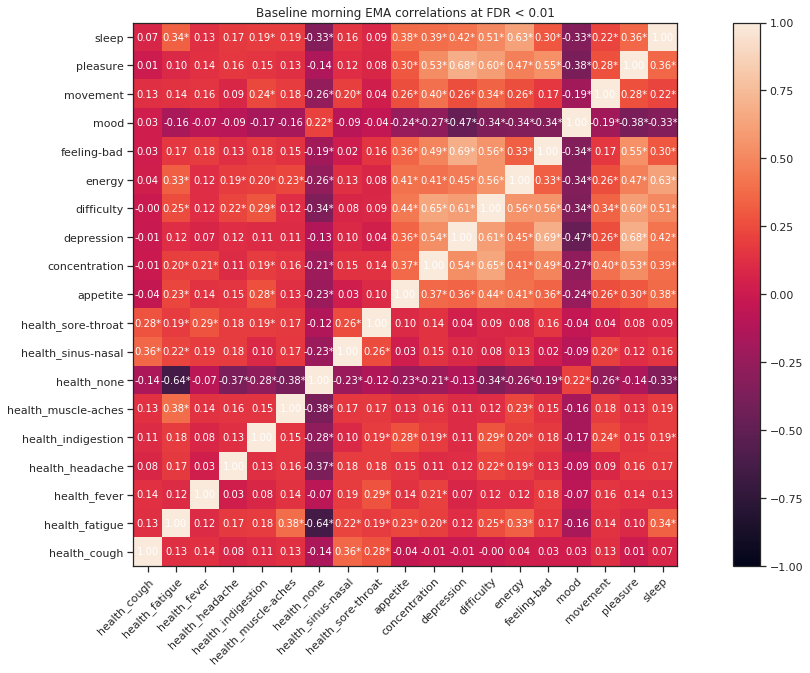

In [85]:
corr_df = even_phq8_emas[corr_cols]
corr_df = corr_df.dropna()
#corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[20,10])
plt.show()

In [86]:
even_phq8_emas.columns[even_phq8_emas.columns.str.startswith("health")]

Index(['health_cough', 'health_fatigue', 'health_fever', 'health_headache',
       'health_indigestion', 'health_muscle-aches', 'health_none',
       'health_sinus-nasal', 'health_sore-throat'],
      dtype='object')

In [87]:
health_df = even_phq8_emas[even_phq8_emas.columns[even_phq8_emas.columns.str.startswith("health")]]
health_df['pid'] = even_phq8_emas['pid'].astype(str)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Daily State Statistics

## Load data

In [88]:
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_scr = pd.read_pickle("ls_data/all_scr.df")
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_fus = pd.read_pickle("ls_data/all_fus.df")

all_sloc_df = pd.read_pickle("ls_data/all_sloc.df")
sloc_hr_all = pd.read_pickle("ls_data/all_sloc_hr.df")

## Foreground application and screen time

In [89]:
apps = [
    'katana',
    'orca', 
    'messaging',
    'launcher',
    'chrome',
    'email',
    'instagram',
    'youtube',
    'maps',
    'snapchat',
    'browser'
]

In [90]:
all_fga.head()

,hr,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,pid
0,2019-07-27 12:00:00,"1,771.000",0.000,0.000,105.000,0.000,0.000,405.000,0.000,0.000,0.000,0.000,08343773
1,2019-07-27 13:00:00,"1,336.000",0.000,0.000,255.000,315.000,0.000,195.000,0.000,0.000,0.000,0.000,08343773
2,2019-07-27 14:00:00,"1,666.000",0.000,0.000,180.000,0.000,0.000,330.000,0.000,0.000,0.000,0.000,08343773
3,2019-07-27 15:00:00,"1,997.000",0.000,0.000,309.000,165.000,0.000,195.000,0.000,60.000,0.000,0.000,08343773
4,2019-07-27 16:00:00,"1,289.000",0.000,0.000,379.000,0.000,0.000,75.000,0.000,0.000,0.000,0.000,08343773


In [91]:
all_fga[apps] = all_fga[apps].clip(lower=0)
all_fga['date'] = all_fga['hr'].dt.floor('d')

In [92]:
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()

In [93]:
fga_daily = fga_daily.loc[(fga_daily['date'] >= ema_df['date'].min()) & (fga_daily['date'] <= ema_df['date'].max())]

In [94]:
all_scr['date'] = all_scr['hr'].dt.floor('d')
scr_daily = all_scr.groupby(['pid', 'date']).sum()
scr_daily = scr_daily.reset_index()
scr_daily = scr_daily.loc[(scr_daily['date'] >= ema_df['date'].min()) & (scr_daily['date'] <= ema_df['date'].max())]

In [95]:
fga_daily = fga_daily.merge(scr_daily, on=['pid', 'date'], how='left')

In [96]:
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)
fga_daily.describe()
#fga_daily = fga_daily.loc[fga_daily['katana'] > 0]

,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,duration,transitions,is_wkday
count,"2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,447.000","2,447.000","2,481.000"
mean,"1,489.510",226.260,971.986,"2,376.241","1,871.144",47.241,473.198,935.700,401.342,97.198,181.079,"14,577.313",124.540,0.777
std,"2,750.172",925.241,"1,670.616","3,742.906","3,431.834",218.650,"1,192.351","3,762.191","1,331.965",419.194,776.265,"8,725.951",106.324,0.416
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,534.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"8,081.500",51.000,1.000
50%,30.000,0.000,245.000,"1,300.000",631.000,0.000,0.000,0.000,0.000,0.000,0.000,"13,962.000",97.000,1.000
75%,"1,865.000",60.000,"1,219.000","2,831.000","2,232.000",0.000,216.000,60.000,105.000,0.000,0.000,"20,331.000",166.000,1.000
max,"20,526.000","14,697.000","19,975.000","58,938.000","40,185.000","3,947.000","15,024.000","58,634.000","21,205.000","5,759.000","15,499.000","52,721.000",853.000,1.000


In [97]:
fga_daily.to_pickle("ls_data/fga_daily.df")

### Correlations

In [98]:
init_df[spin_cols] = baseline_df[spin_cols]

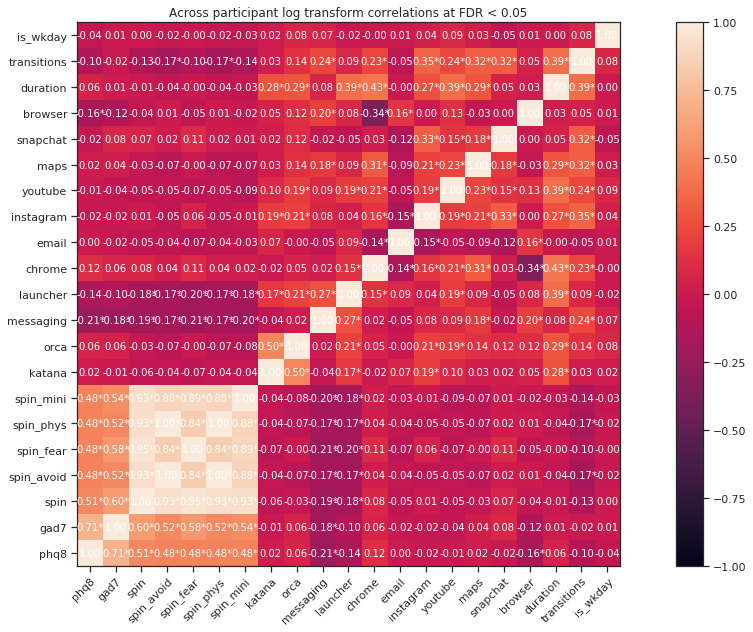

In [99]:
fga_mean = fga_daily.groupby('pid').mean()
fga_mean = np.log(fga_mean + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df['gad7'] = corr_df['gad7'].clip(upper=21)
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[20,10])
plt.show()

#### Health

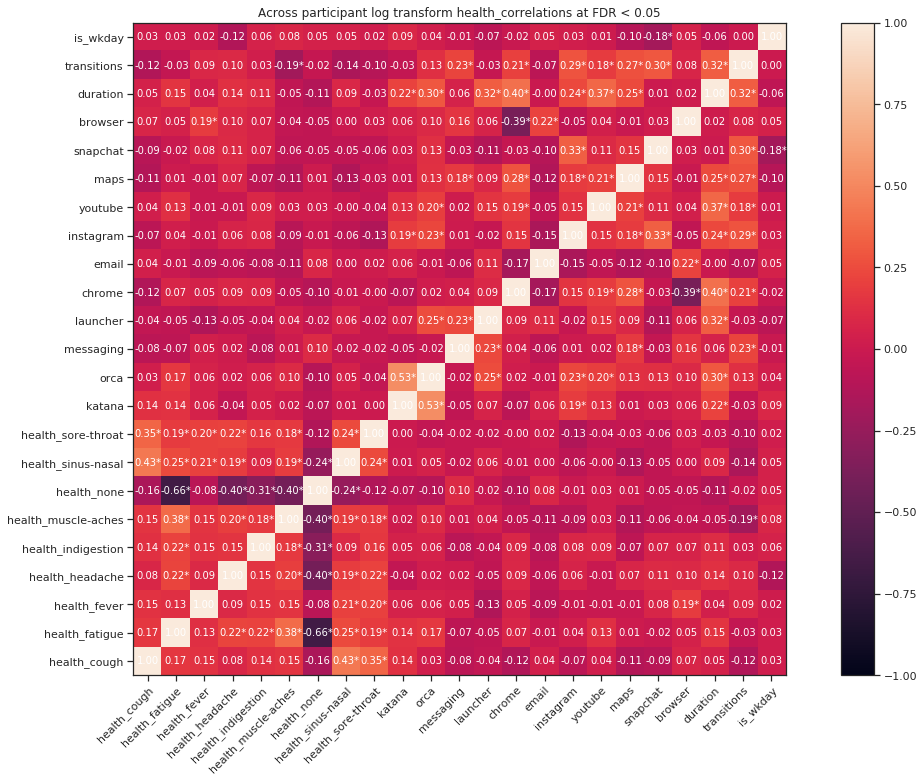

In [100]:
fga_mean = fga_daily.groupby('pid').mean()
fga_mean = np.log(fga_mean + 1)
health_corr_df = health_df.copy()
health_corr_df = health_corr_df.merge(fga_mean, on='pid', how='left')
health_corr_df = health_corr_df.dropna()
health_corr_df = health_corr_df.drop(['pid'], axis='columns')
health_corrs, _, p_vals = run_r_corr(health_corr_df)
plt = build_corr_mat(health_corrs, p_vals, health_corr_df.columns.values, 'Across participant log transform health_correlations at FDR < 0.05', 0.05, figsize=[20,12])
plt.show()

### Partial correlations controlling for PHQ8

#### All days of week

In [101]:
# all days of week
build_partial_corr(corr_df, 'spin', 'phq8')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/pairwise.py:1097: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.round(np.arctanh(stats['r'].values), 3)


,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.163,0.007,-0.182,0.002
1,spin,duration,['phq8'],-0.142,0.018,-0.093,0.124
2,spin,transitions,['phq8'],-0.157,0.009,-0.175,0.004
3,spin_avoid,launcher,['phq8'],-0.167,0.005,-0.186,0.002
4,spin_avoid,maps,['phq8'],-0.134,0.026,-0.110,0.069
5,spin_avoid,browser,['phq8'],0.120,0.047,0.031,0.614
6,spin_avoid,duration,['phq8'],-0.176,0.003,-0.128,0.034
7,spin_avoid,transitions,['phq8'],-0.211,0.000,-0.223,0.000
8,spin_fear,launcher,['phq8'],-0.176,0.003,-0.194,0.001
9,spin_fear,duration,['phq8'],-0.143,0.017,-0.098,0.105


#### Weekdays

In [102]:
# weekdays

fga_wkday = fga_daily.loc[fga_daily['is_wkday'] == 1]
fga_mean_wkday = fga_wkday.groupby('pid').mean()
fga_mean_wkday = np.log(fga_mean_wkday + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df['gad7'] = corr_df['gad7'].clip(upper=21)
corr_df = corr_df.merge(fga_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.163,0.007,-0.187,0.002
1,spin,duration,['phq8'],-0.141,0.019,-0.096,0.113
2,spin,transitions,['phq8'],-0.147,0.015,-0.167,0.006
3,spin_avoid,launcher,['phq8'],-0.172,0.004,-0.195,0.001
4,spin_avoid,maps,['phq8'],-0.135,0.025,-0.102,0.091
5,spin_avoid,duration,['phq8'],-0.175,0.004,-0.130,0.031
6,spin_avoid,transitions,['phq8'],-0.201,0.001,-0.215,0.000
7,spin_fear,launcher,['phq8'],-0.181,0.003,-0.203,0.001
8,spin_fear,snapchat,['phq8'],0.132,0.028,0.104,0.084
9,spin_fear,duration,['phq8'],-0.145,0.016,-0.103,0.088


#### Weekends

In [103]:
# weekends
fga_wkend = fga_daily.loc[fga_daily['is_wkday'] == 0]
fga_mean_wkend = fga_wkend.groupby('pid').mean()
fga_mean_wkend = np.log(fga_mean_wkend + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fga_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.139,0.022,-0.155,0.010
1,spin,duration,['phq8'],-0.140,0.021,-0.100,0.100
2,spin,transitions,['phq8'],-0.191,0.002,-0.200,0.001
3,spin_avoid,orca,['phq8'],-0.122,0.045,-0.108,0.075
4,spin_avoid,launcher,['phq8'],-0.148,0.014,-0.164,0.007
5,spin_avoid,duration,['phq8'],-0.170,0.005,-0.131,0.031
6,spin_avoid,transitions,['phq8'],-0.237,0.000,-0.241,0.000
7,spin_fear,messaging,['phq8'],-0.136,0.025,-0.206,0.001
8,spin_fear,launcher,['phq8'],-0.149,0.014,-0.164,0.007
9,spin_fear,instagram,['phq8'],0.124,0.042,0.103,0.089


### Dump features

In [104]:
fga_mean_all = pd.merge(fga_mean_wkend.add_suffix("_wkend"), 
                        fga_mean_wkday.add_suffix("_wkday"), 
                        left_index=True, right_index=True)

fga_mean_all = fga_mean_all[[c for c in fga_mean_all.columns if not c.startswith("is_wkday")]]
#fga_mean_all.to_pickle("ls_data/fga_features.df")

## Call and text

In [105]:
baseline_df['routine_slabels09'].value_counts()

1    226
2     56
Name: routine_slabels09, dtype: int64

In [106]:
all_cal['date'] = all_cal['call_hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily = cal_daily.loc[(cal_daily['date'] >= ema_df['date'].min()) & (cal_daily['date'] <= ema_df['date'].max())]

In [107]:
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily = sms_daily.loc[(sms_daily['date'] >= ema_df['date'].min()) & (sms_daily['date'] <= ema_df['date'].max())]

In [108]:
#comm_daily = scr_daily.merge(cal_daily, on=['pid', 'date'], how='left')
comm_daily = cal_daily.merge(sms_daily, on=['pid', 'date'], how='left')

comm_daily["is_wkday"] = (pd.to_datetime(comm_daily['date']).dt.dayofweek < 5).astype(float)

comm_mean = comm_daily.groupby('pid').mean()
comm_mean = np.log(comm_mean + 1)


### Texting Response Time

In [109]:
sms_response = pd.read_pickle("ls_data/response_sms.df")

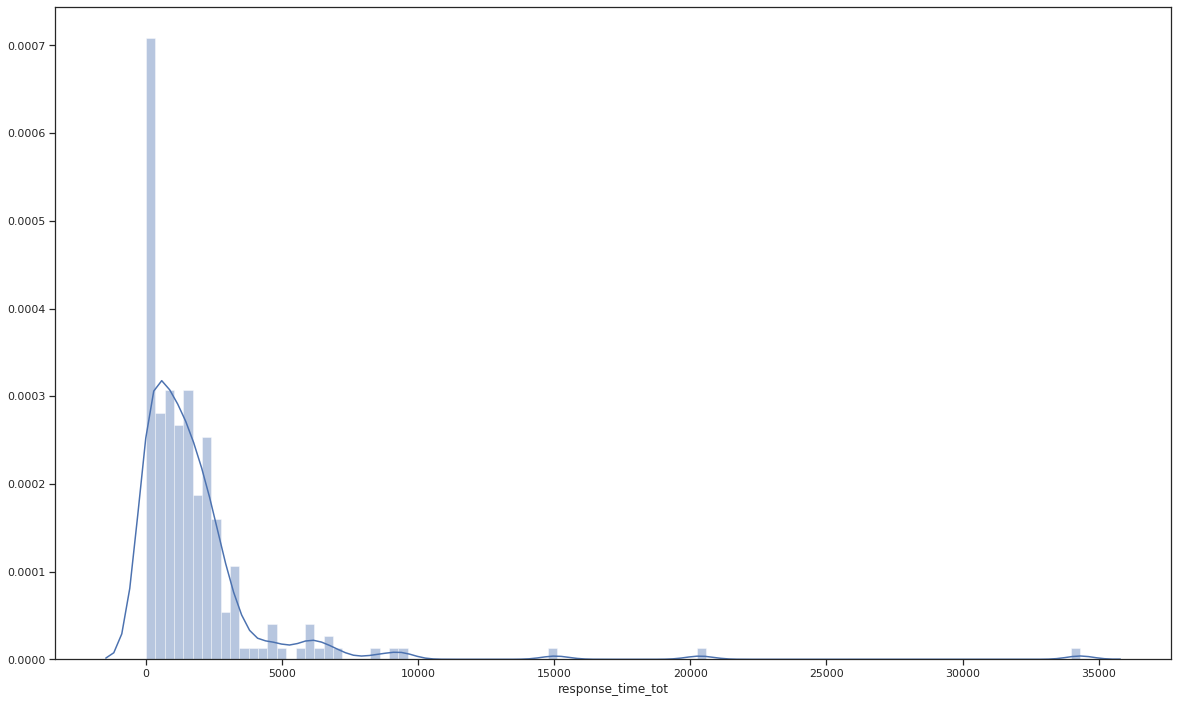

In [110]:
sns.distplot(sms_response.loc[~sms_response['response_time_tot'].isna()]['response_time_tot'], bins=100)

In [111]:
sms_response['response_time_tot'] = np.log(sms_response['response_time_tot'] + 1)
sms_response['response_time_wkday'] = np.log(sms_response['response_time_wkday'] + 1)
sms_response['response_time_wkend'] = np.log(sms_response['response_time_wkend'] + 1)


In [112]:
sms_response.head()

,pid,response_time_tot,response_time_wkday,response_time_wkend,unique_contacts
0,08343773,3.434,0.000,4.111,13
0,18583649,7.288,7.484,5.271,18
0,99050875,5.757,5.757,nan,126
0,31456993,nan,nan,nan,18
0,01495950,nan,nan,nan,14


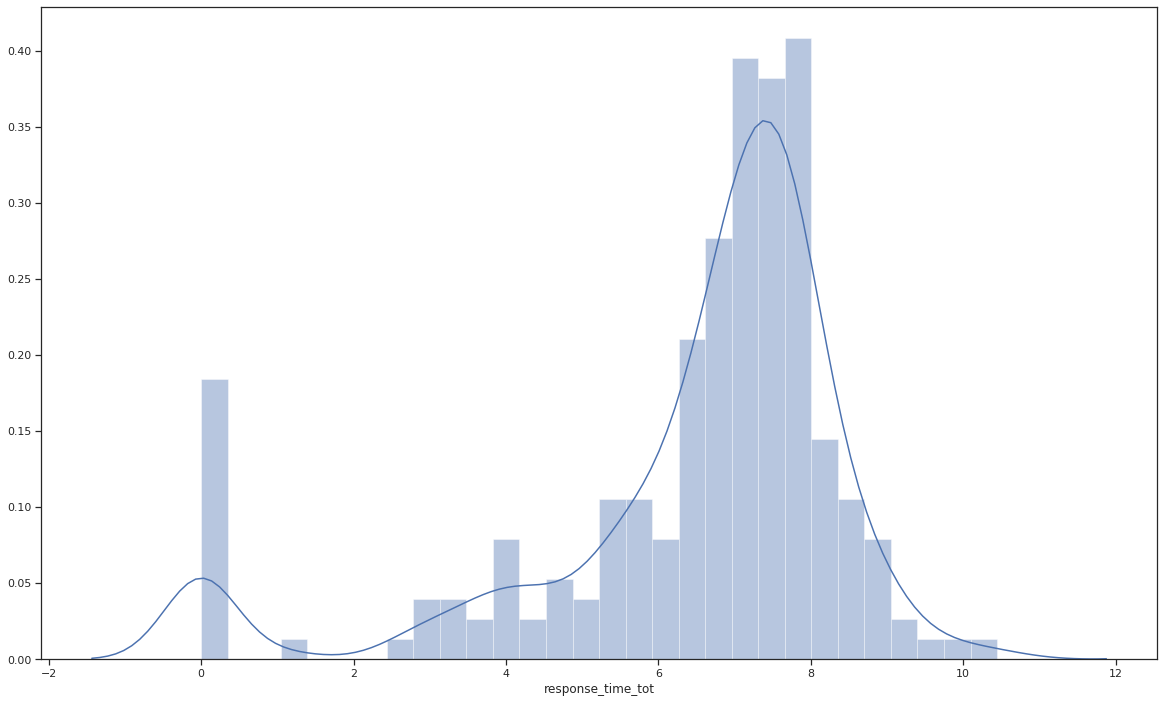

In [113]:
sns.distplot(sms_response.loc[~sms_response['response_time_tot'].isna()]['response_time_tot'], bins=30)
plt.show()

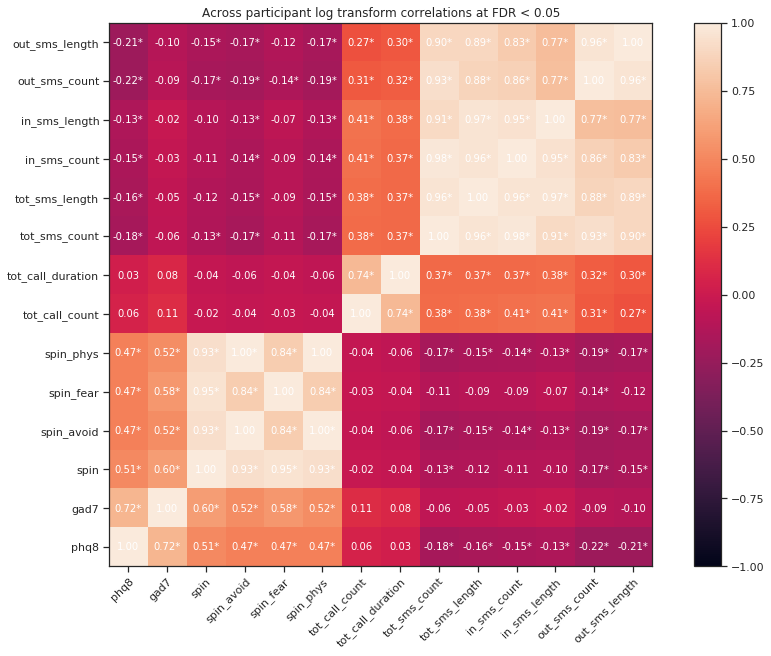

In [114]:
#init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.xlim(-0.5,corr_df.shape[1] - .5)
plt.ylim(-0.5,corr_df.shape[1] - .5)
plt.show()

(156, 18)


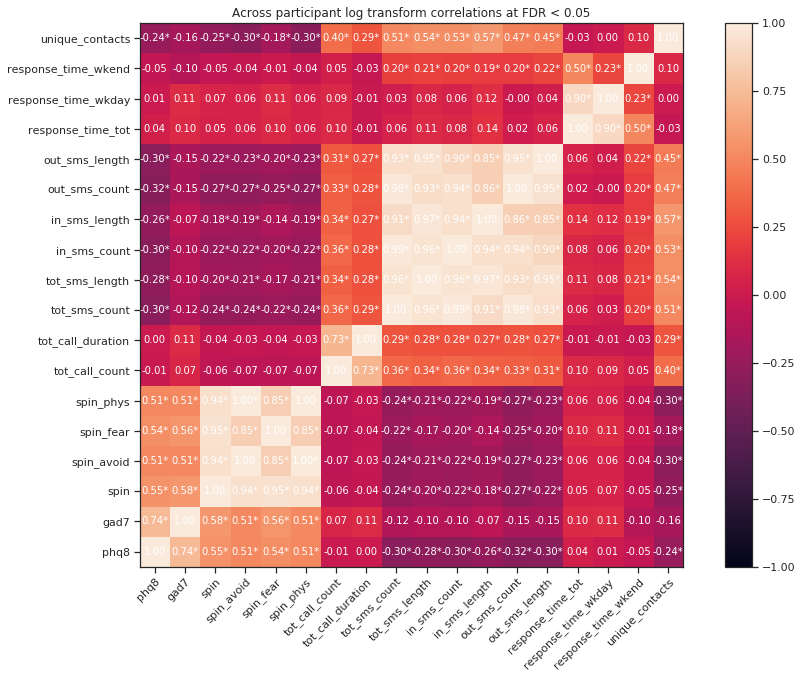

In [115]:
#init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean, on='pid', how='left')
corr_df = corr_df.merge(sms_response, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
print(corr_df.shape)
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.xlim(-0.5,17.5)
plt.ylim(-0.5,17.5)
plt.show()

### Partial correlations controlling for PHQ8

#### All Days

In [116]:
# all days
build_partial_corr(corr_df, 'spin', 'phq8')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/pairwise.py:1097: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.round(np.arctanh(stats['r'].values), 3)


,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


#### Weekdays

In [117]:
# weekdays
comm_wkday = comm_daily.loc[comm_daily['is_wkday'] == 1]
comm_mean_wkday = comm_wkday.groupby('pid').mean()
comm_mean_wkday = np.log(comm_mean_wkday + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin_avoid,tot_call_duration,['phq8'],-0.144,0.019,-0.097,0.116
1,spin_phys,tot_call_duration,['phq8'],-0.144,0.019,-0.097,0.116


#### Weekends

In [118]:
# weekdays
comm_wkend = comm_daily.loc[comm_daily['is_wkday'] == 0]
comm_mean_wkend = comm_wkend.groupby('pid').mean()
comm_mean_wkend = np.log(comm_mean_wkend + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,tot_sms_count,['phq8'],-0.147,0.017,-0.187,0.002
1,spin,tot_sms_length,['phq8'],-0.172,0.005,-0.168,0.006
2,spin,in_sms_count,['phq8'],-0.131,0.033,-0.164,0.008
3,spin,in_sms_length,['phq8'],-0.159,0.010,-0.144,0.019
4,spin,out_sms_count,['phq8'],-0.131,0.033,-0.202,0.001
5,spin,out_sms_length,['phq8'],-0.141,0.023,-0.178,0.004
6,spin_avoid,tot_sms_count,['phq8'],-0.200,0.001,-0.231,0.000
7,spin_avoid,tot_sms_length,['phq8'],-0.215,0.000,-0.208,0.001
8,spin_avoid,in_sms_count,['phq8'],-0.187,0.002,-0.211,0.001
9,spin_avoid,in_sms_length,['phq8'],-0.203,0.001,-0.186,0.002


### Dump features

In [ ]:
comm_mean_all = pd.merge(comm_mean_wkend.add_suffix("_wkend"), 
                        comm_mean_wkday.add_suffix("_wkday"), 
                        left_index=True, right_index=True)

comm_mean_all = comm_mean_all[[c for c in comm_mean_all.columns if not c.startswith("is_wkday")]]
comm_mean_all = comm_mean_all.merge(sms_response.set_index('pid'), 
                                    left_index=True, right_index=True)
#comm_mean_all.head()
#comm_mean_all.to_pickle("ls_data/comm_features.df")

## Fused Location

In [120]:
fus_daily = all_fus.loc[(all_fus['date'] >= ema_df['date'].min()) & (all_fus['date'] <= ema_df['date'].max())]

fus_daily['norm_entropy'] = fus_daily['entropy'] / np.log(fus_daily['cluster'] + 1)
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [121]:
fus_daily.to_pickle("ls_data/fus_daily.df")

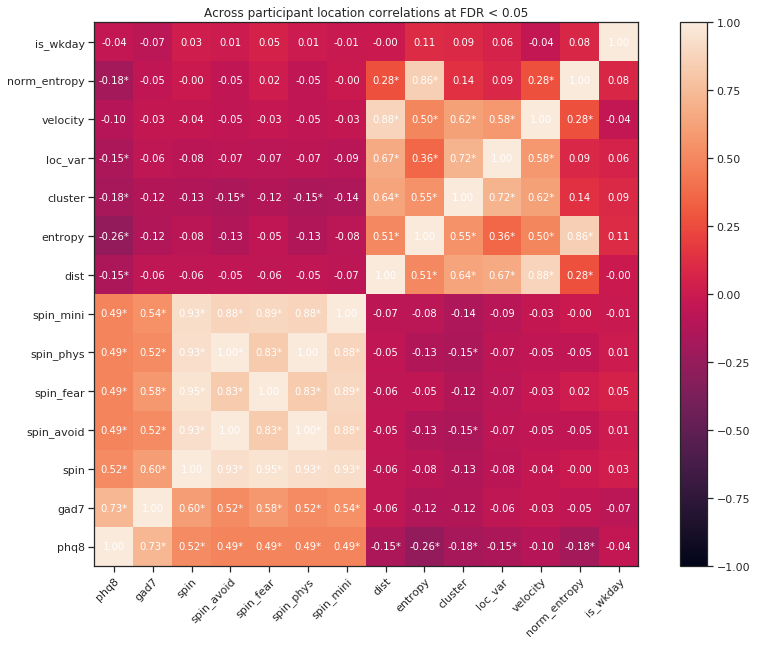

In [122]:
fus_mean = fus_daily.groupby('pid').mean()

init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant location correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.show()

### Circadian Movement

In [123]:
circ_df = pd.read_pickle("ls_data/circ_movt.df")

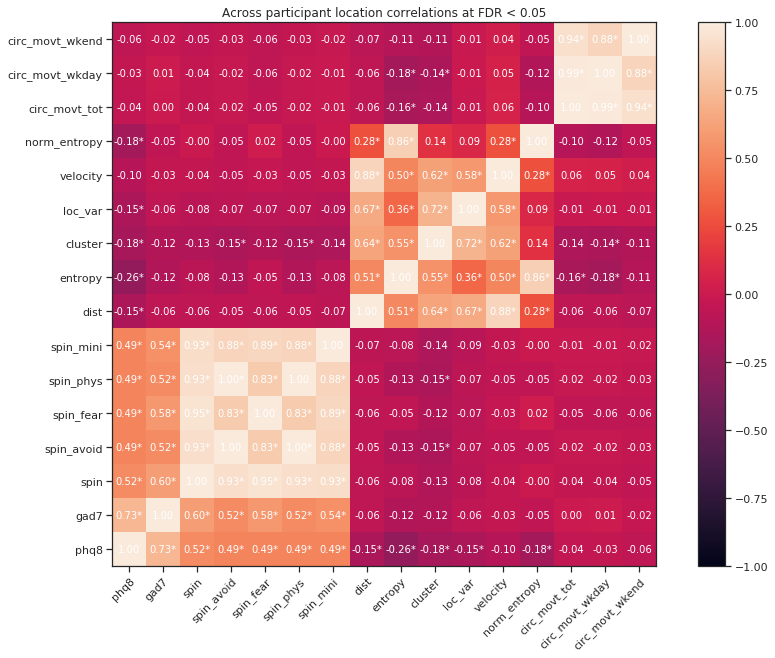

In [124]:
fus_mean = fus_daily.groupby('pid').mean()

init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean, on='pid', how='left')
corr_df = corr_df.merge(circ_df, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)

plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant location correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.ylim(-0.5, corr_df.shape[1]-0.5)
plt.xlim(-0.5, corr_df.shape[1]-0.5)
plt.show()

#### Health

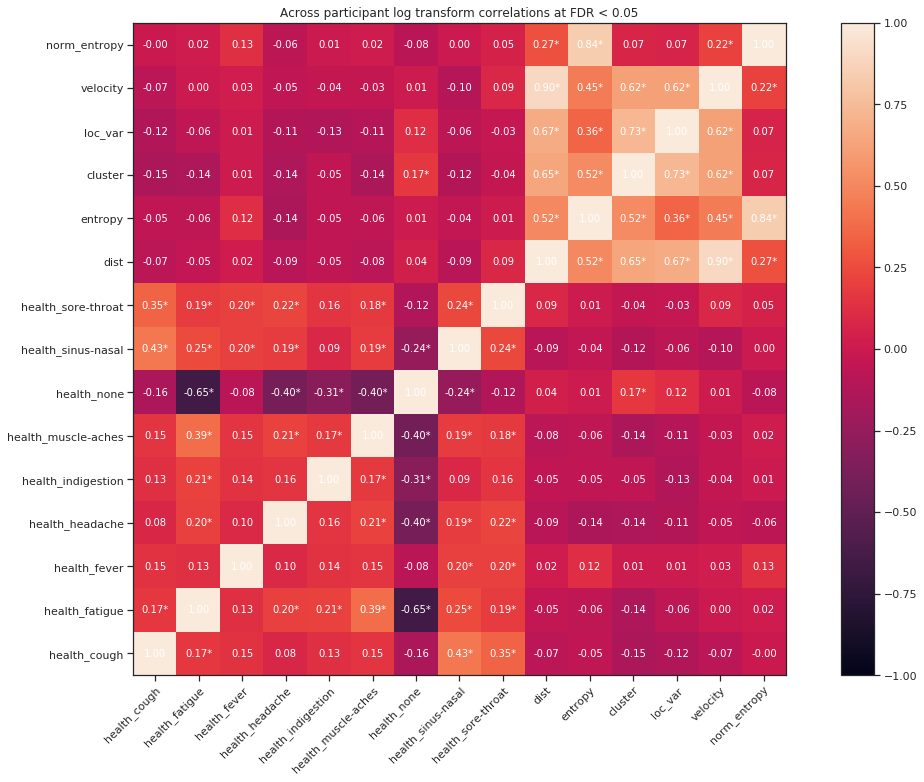

In [125]:
fus_mean = fus_daily.groupby('pid').mean()
health_corr_df = health_df.copy()
health_corr_df = health_corr_df.merge(fus_mean, on='pid', how='left')
health_corr_df = health_corr_df.replace([np.inf, -np.inf], np.nan)
health_corr_df = health_corr_df.dropna()
health_corr_df = health_corr_df.drop(['pid', 'is_wkday'], axis='columns')
#display(health_corr_df)
corrs, _, p_vals = run_r_corr(health_corr_df)
plt = build_corr_mat(corrs, p_vals, health_corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[20,12])
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [126]:
build_partial_corr(corr_df, 'spin', 'phq8')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/pairwise.py:1097: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.round(np.arctanh(stats['r'].values), 3)


,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin_fear,norm_entropy,['phq8'],0.130,0.034,0.020,0.748


#### Weekday

In [127]:
fus_wkday = fus_daily[fus_daily['is_wkday'] == 1]
fus_mean_wkday = fus_wkday.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkday, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,norm_entropy,['phq8'],0.124,0.043,0.018,0.765
1,spin_fear,norm_entropy,['phq8'],0.141,0.022,0.040,0.520


#### Weekend

In [128]:
fus_wkend = fus_daily[fus_daily['is_wkday'] == 0]
fus_mean_wkend = fus_wkend.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkend, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


### Dump features

In [ ]:
fus_mean_all = pd.merge(fus_mean_wkend.add_suffix("_wkend"), 
                        fus_mean_wkday.add_suffix("_wkday"), 
                        left_index=True, right_index=True)

fus_mean_all = fus_mean_all[[c for c in fus_mean_all.columns if not c.startswith("is_wkday")]]
fus_mean_all = fus_mean_all.merge(circ_df.set_index('pid'), 
                                    left_index=True, right_index=True)
fus_mean_all = fus_mean_all.replace([np.inf, -np.inf], np.nan)
#fus_mean_all.head()
#fus_mean_all.to_pickle("ls_data/fus_features.df")

## Semantic Location Duration

In [130]:
dur_cols = list(sloc_hr_all.columns[sloc_hr_all.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = sloc_hr_all[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [131]:
sloc_dur_df = sloc_dur_df.loc[(sloc_dur_df['date'] >= ema_df['date'].min()) & (sloc_dur_df['date'] <= ema_df['date'].max())]

sloc_dur_df["is_wkday"] = (pd.to_datetime(sloc_dur_df['date']).dt.dayofweek < 5).astype(float)
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [132]:
spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

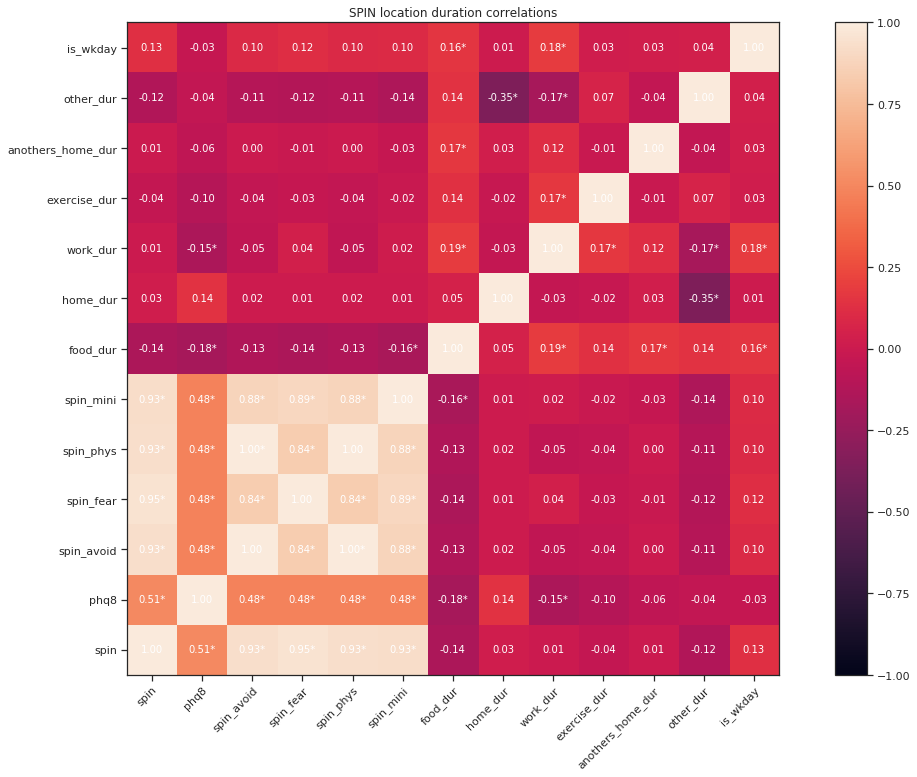

In [133]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'SPIN location duration correlations', 0.05, figsize=[20,12])
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [134]:
build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,other_dur,['phq8'],-0.135,0.026,-0.122,0.044
1,spin_avoid,other_dur,['phq8'],-0.149,0.013,-0.137,0.023
2,spin_fear,work_dur,['phq8'],0.126,0.038,0.031,0.615
3,spin_fear,other_dur,['phq8'],-0.141,0.020,-0.129,0.033
4,spin_phys,other_dur,['phq8'],-0.149,0.013,-0.137,0.023
5,spin_mini,other_dur,['phq8'],-0.184,0.002,-0.168,0.006


#### Weekdays

In [135]:
sloc_dur_wkday = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 1]
mean_dur_wkday = sloc_dur_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkday = mean_dur_wkday.groupby('pid', as_index=False).mean()

spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys']]
spin_dur = spin_dur.merge(mean_dur_wkday, on='pid', how='left')
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['is_wkday'], axis='columns')

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,work_dur,['phq8'],0.121,0.046,0.015,0.808
1,spin_avoid,other_dur,['phq8'],-0.135,0.025,-0.134,0.027
2,spin_fear,work_dur,['phq8'],0.141,0.020,0.039,0.524
3,spin_fear,other_dur,['phq8'],-0.121,0.046,-0.120,0.047
4,spin_phys,other_dur,['phq8'],-0.135,0.025,-0.134,0.027


#### Weekends

In [136]:
sloc_dur_wkend = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 0]
mean_dur_wkend = sloc_dur_wkend.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkend = mean_dur_wkend.groupby('pid', as_index=False).mean()

spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys']]
spin_dur = spin_dur.merge(mean_dur_wkend, on='pid', how='left')
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Semantic Location Transitions

In [137]:
trans_cols = list(sloc_hr_all.columns[~sloc_hr_all.columns.str.contains("dur")].values)
sloc_trans_df = sloc_hr_all[trans_cols]
sloc_trans_df['date'] = sloc_trans_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [138]:
sloc_trans_df = sloc_trans_df.loc[(sloc_trans_df['date'] >= ema_df['date'].min()) & (sloc_trans_df['date'] <= ema_df['date'].max())]
sloc_trans_df["is_wkday"] = (pd.to_datetime(sloc_trans_df['date']).dt.dayofweek < 5).astype(float)

mean_trans_df = sloc_trans_df.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

In [139]:
mean_trans_df.describe()

,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,home_exercise,...,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions,is_wkday
count,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,...,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000
mean,0.043,0.020,0.002,0.009,0.000,0.000,0.168,0.037,0.048,0.013,...,0.000,0.166,1.085,0.473,0.056,0.148,0.000,0.000,4.220,18.523
std,0.126,0.077,0.015,0.057,0.000,0.000,0.273,0.117,0.217,0.069,...,0.000,0.263,1.257,0.675,0.186,0.437,0.000,0.000,3.791,0.888
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.750
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.444,0.000,0.000,0.000,0.000,0.000,1.889,18.667
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.889,0.278,0.000,0.000,0.000,0.000,3.667,18.667
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.222,0.000,0.000,0.000,...,0.000,0.222,1.333,0.729,0.000,0.111,0.000,0.000,5.667,18.667
max,0.778,0.667,0.111,0.667,0.000,0.000,1.444,1.000,2.556,0.667,...,0.000,1.222,11.778,5.333,1.667,5.556,0.000,0.000,30.444,23.000


In [140]:
spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

### Partial Correlations Correcting for PHQ8

#### All days

In [141]:
corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin_fear,work_other,['phq8'],0.129,0.033,0.060,0.323
1,spin_fear,other_work,['phq8'],0.136,0.025,0.083,0.169


#### Weekdays

In [142]:
sloc_trans_wkday = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 1]
mean_trans_wkday = sloc_trans_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_wkday = mean_trans_wkday.groupby('pid', as_index=False).mean()

spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_wkday, on='pid', how='left')

corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,other_work,['phq8'],0.129,0.032,0.065,0.288
1,spin_fear,work_other,['phq8'],0.146,0.016,0.066,0.274
2,spin_fear,other_work,['phq8'],0.155,0.010,0.092,0.131


#### Weekends

In [143]:
sloc_trans_wkend = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 0]
mean_trans_wkend = sloc_trans_wkend.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_wkend = mean_trans_wkend.groupby('pid', as_index=False).mean()

spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_wkend, on='pid', how='left')

corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


### Dump features

In [144]:
mean_trans_wkend = mean_trans_wkend.set_index("pid")
mean_trans_wkday = mean_trans_wkday.set_index("pid")

mean_dur_wkend = mean_dur_wkend.set_index("pid")
mean_dur_wkday = mean_dur_wkday.set_index("pid")

In [ ]:
mean_sloc_all = pd.merge(mean_trans_wkend.add_suffix("_wkend"), 
                        mean_trans_wkday.add_suffix("_wkday"), 
                        left_index=True, right_index=True)
mean_sloc_all = mean_sloc_all.merge(mean_dur_wkend.add_suffix("_wkend"), 
                                    left_index=True, right_index=True)
mean_sloc_all = mean_sloc_all.merge(mean_dur_wkday.add_suffix("_wkday"), 
                                    left_index=True, right_index=True)

mean_sloc_all = mean_sloc_all[[c for c in mean_sloc_all.columns if not c.startswith("is_wkday")]]

#mean_sloc_all.head()
#mean_sloc_all.to_pickle("ls_data/sloc_features.df")

# Temporal Patterns

### Facebook Use

In [146]:
fga_filter = all_fga.loc[(all_fga['date'] >= ema_df['date'].min()) & (all_fga['date'] <= ema_df['date'].max())]

In [147]:
facebook_pivot = fga_filter.pivot(index='pid', columns='hr', values='katana')
pids = facebook_pivot.index

In [148]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [149]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [150]:
facebook_pivot = facebook_pivot.fillna(0)

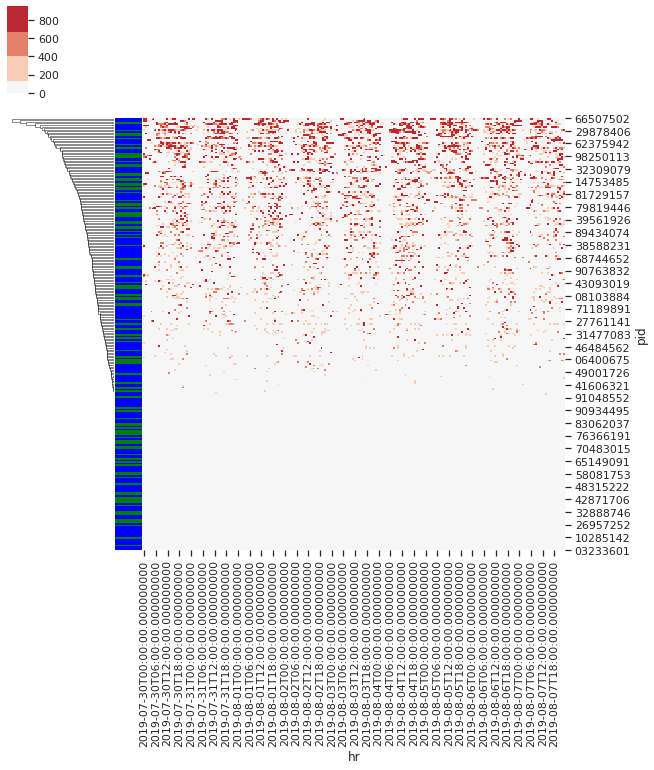

In [151]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(facebook_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### Messages Use

In [152]:
msg_pivot = fga_filter.pivot(index='pid', columns='hr', values='messaging')
pids = msg_pivot.index

In [153]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [154]:
msg_pivot = msg_pivot.fillna(0)

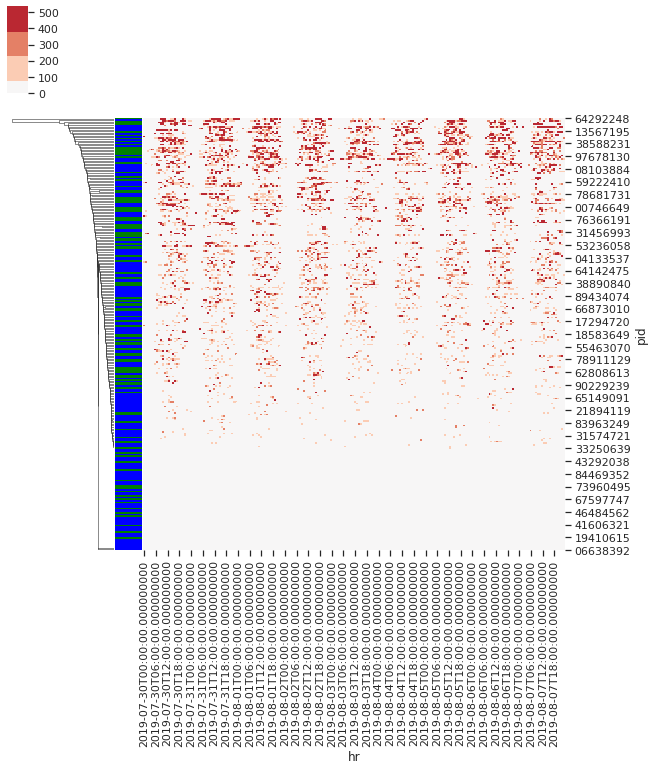

In [155]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(msg_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

#### Single day

In [156]:
fga_single = all_fga.loc[all_fga['date'] == '2019-07-31']
msg_pivot = fga_single.pivot(index='pid', columns='hr', values='messaging')
pids = msg_pivot.index

In [157]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [158]:
msg_pivot = msg_pivot.fillna(0)

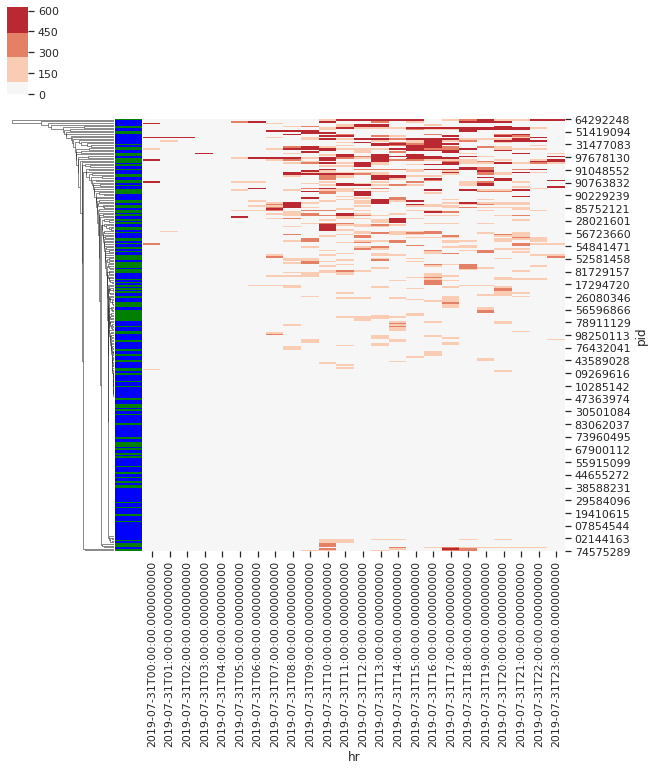

In [159]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(msg_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### Morning EMAs

In [160]:
ema_df = ema_df.drop_duplicates(subset=['pid', 'date'])
ema_filter = ema_df.loc[(ema_df['date'] >= '2019-07-31') & (ema_df['date'] <= '2019-08-05')]

In [161]:
morn_pivot = ema_filter.pivot(index='pid', columns='date', values='morn_mood')
pids = morn_pivot.index

In [162]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [163]:
morn_pivot = morn_pivot.fillna(0)

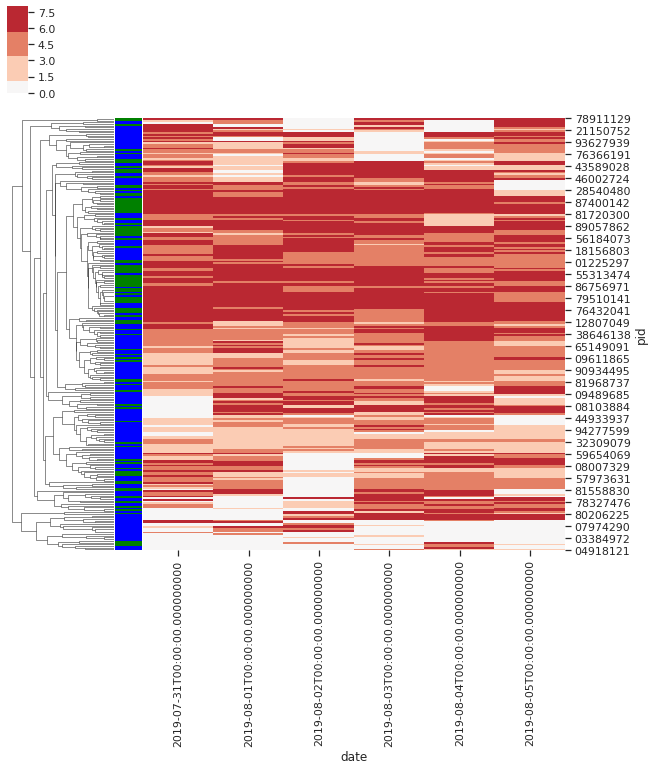

In [164]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(morn_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### SMS

In [165]:
sms_filter = all_sms.loc[(all_sms['date'] >= ema_df['date'].min()) & (all_sms['date'] <= ema_df['date'].max())]

In [166]:
sms_pivot = sms_filter.pivot(index='pid', columns='hour', values='out_sms_count')
pids = sms_pivot.index

In [167]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [168]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [169]:
sms_pivot = sms_pivot.fillna(0)

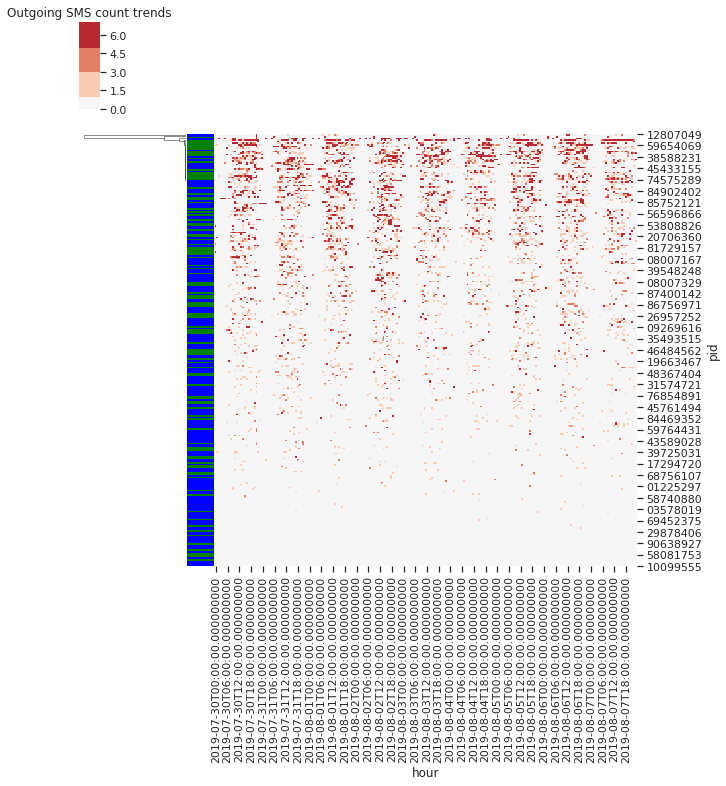

In [170]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(sms_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
plt.title("Outgoing SMS count trends")
plt.show()

### Three days

In [171]:
sms_filter = all_sms.loc[(all_sms['date'] >= '2019-07-31') & (all_sms['date'] <= '2019-08-02')]

In [172]:
sms_pivot = sms_filter.pivot(index='pid', columns='hour', values='out_sms_count')
pids = sms_pivot.index

In [173]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [174]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [175]:
sms_pivot = sms_pivot.fillna(0)

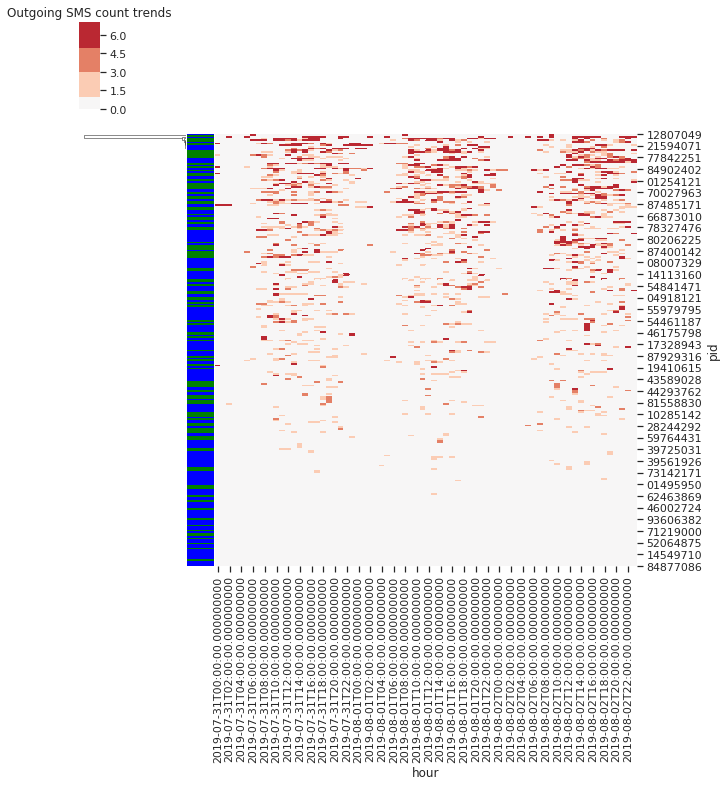

In [176]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(sms_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
plt.title("Outgoing SMS count trends")
plt.show()